**INTRODUCTION**



Building from the simple scheduler we have built in the class, I design a more complex scheduler with these characteristics:

\(1\) The property of the scheduler takes into account tasks with fixed time, tasks with a preferable time range to start such as lunchtime \(11am\-13am\), and tasks with a deadline

\(2\) The scheduler will have an end time, any tasks that exceed this end time will be scheduled on another day

\(3\) The scheduler will prioritize tasks based on an utility function, a combination of different properties in relation to the current time


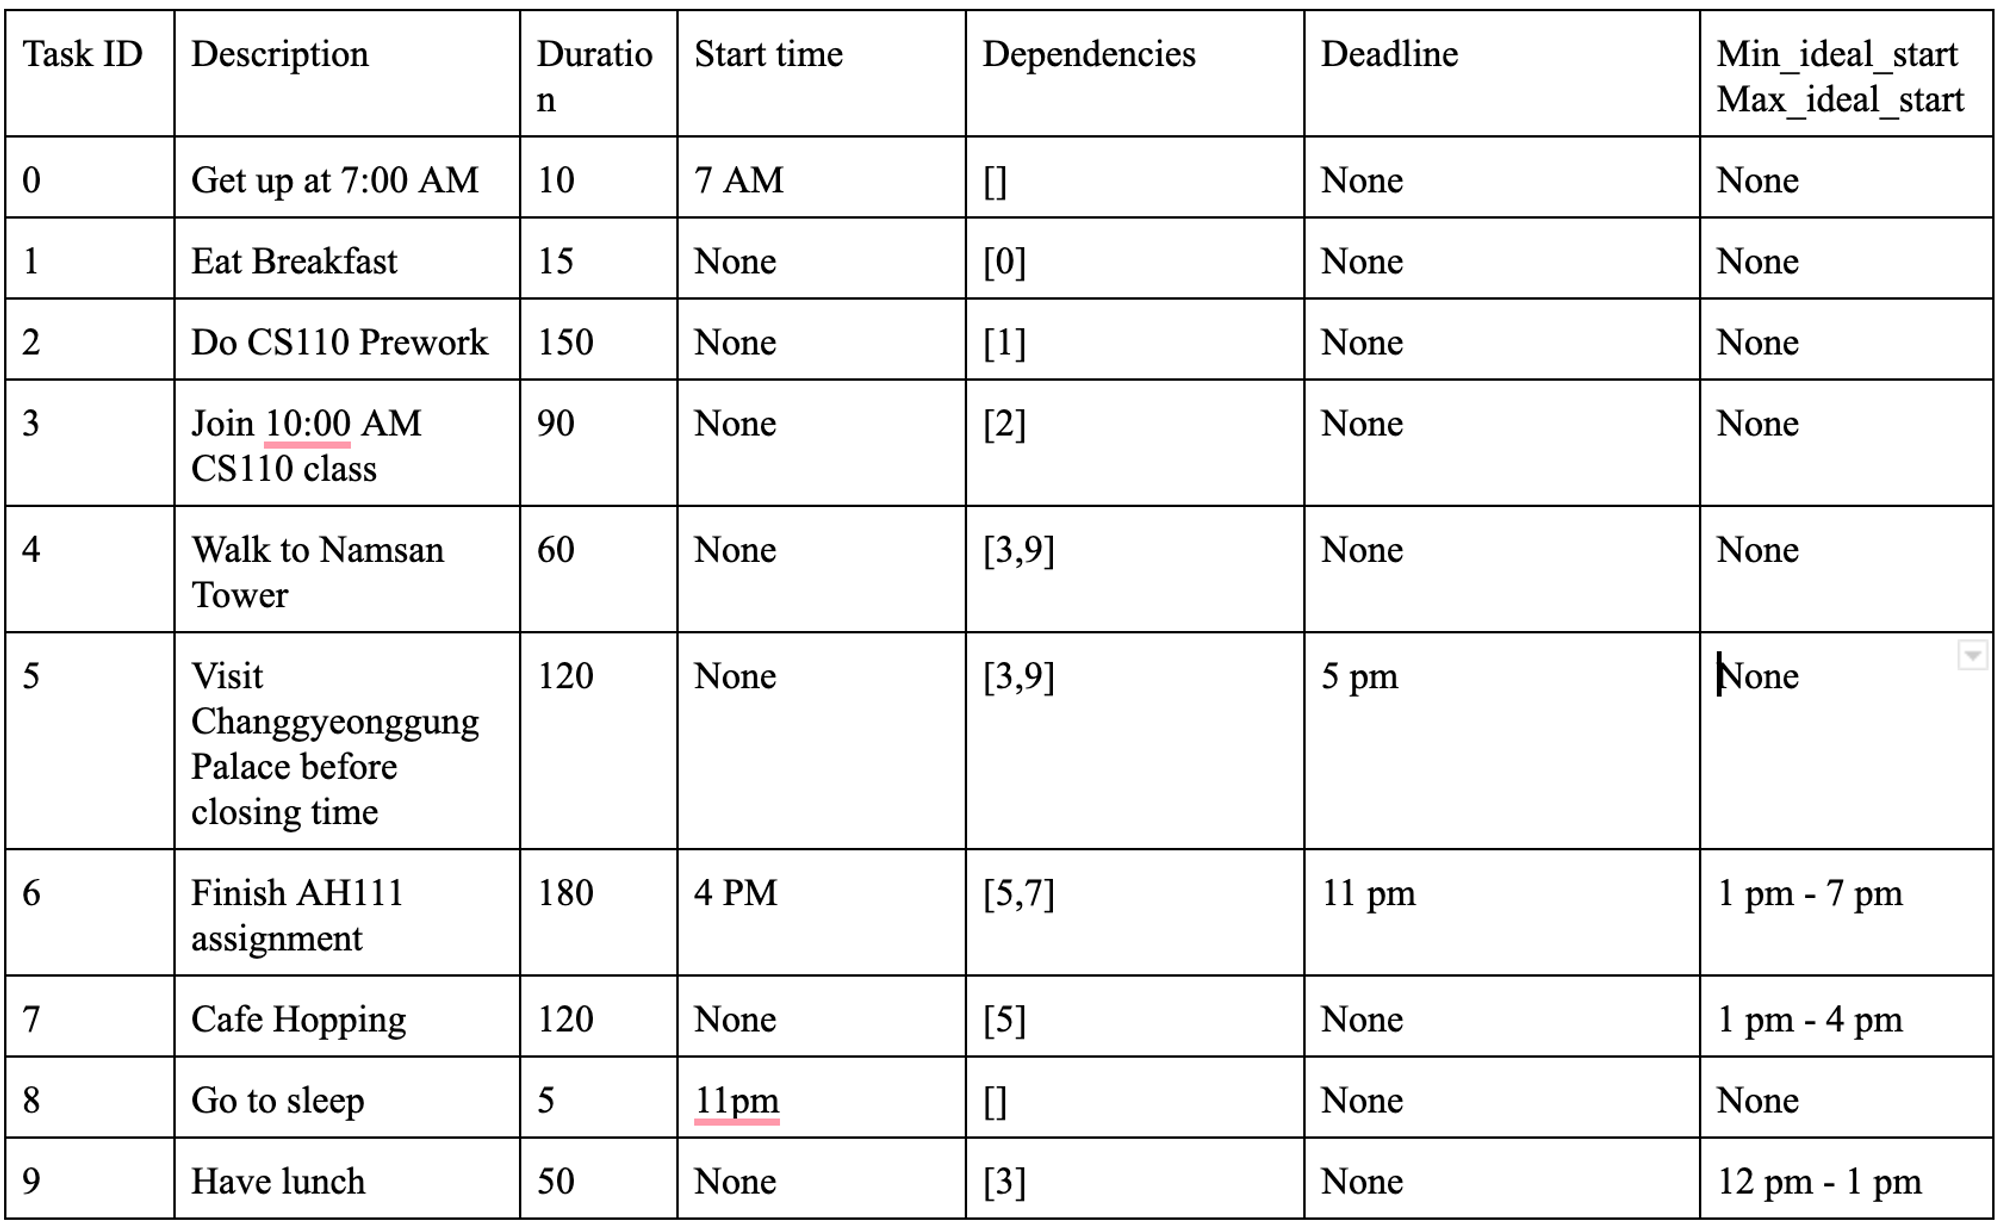

The tasks in the task list are categorized into daily task and city-exploration tasks. 

- Daily tasks include activities such as waking up, cooking and eating: There will be many tasks depend on these daily tasks, for example, I can only explore the city after I eat breakfast/ lunch. Lunch is the task that have an ideal time to start, normally between 11am to 1pm but I still keep its time flexible to deviate outside that range a little bit if I am too busy. 

- Secondly, work-related tasks often have deadline and fixed time to execute. For example, assignments are due at 11pm and class time is unchangable. There will be huge penalties for missing classes like course withdrawal or missing an internship opportunity by missing interviews, so we will receive high utility by completing these tasks on time

Meanwhile, city-exploration are more flexible in time. Visiting a famous attraction is on my bucket list as it allows me to understand more about the history and culture of Seoul. However, still keep in mind that they have ideal time to start, for example, ideally in the afternoon and some city attractions will close after 5pm (deadline)

Here is the snippet of the task's properties:

'''
class Task:

```
A class that represents a task object.

Attributes:
- id (int): Unique identifier of the task.
- description (str): A description of the task.
- duration (int): The duration of the task.
- dependencies (list): The list of task IDs that this task depends on.
- dependents_count (int): The number of tasks that depend on this task.
- status (str): The status of the task. ('N' for not yet started, 'I' for in priority queue, 'C' for completed).
- start_time (int, None): The starting time of the task. Set to an integer if it has a fixed starting time, otherwise None.
- deadline (int, None): The deadline for completing the task. Set to an integer if there's a deadline, otherwise None.
- min_ideal_start (int, None): The earliest ideal start time for the task.Set to an integer if specified, otherwise None.
- max_ideal_start (int, None): The latest ideal starting time for the task. Set to an integer if specified, otherwise None.
- end_time (int, None): The completion time of the task. Set to an integer if the task is completed, otherwise None.
- utility (int): The utility score of the task.
- priority (int): The priority value of the task.
'''
```



### **Utility Calculation:**



The priority of the task is determined by a utility function which is the sum of the utility derived from each task property. The utility is calculated based on the task's relation to the current time that it is ready to be pushed into the priority queue. This will help generate more real\-time utility gain from the task. For example, my utility of visiting a palace will be different if the current time is close to the deadline of another task, vs the case that the current time is free of conflicting schedules.

Here is the code snippet of my utility calculation:



'''
task.utility = 10
if task.start_time is not None:
    task.priority = task.start_time
    return task.priority

else:
    # Calculate urgency score based on deadline
    if task.deadline is not None:
        if current_time < task.deadline:
            urgency_score = 1 - ((task.deadline - current_time - task.duration) / (5*60))
            task.utility += urgency_score
        else:
            urgency_score = (task.deadline - current_time - task.duration) / (5*60)
            task.utility -= urgency_score
    # Calculate score for ideal time range
    ideal_score = 0
    if task.min_ideal_start is not None and task.max_ideal_start is not None:
        if task.min_ideal_start <= current_time <= task.max_ideal_start:
            score_increment = (task.max_ideal_start - current_time ) / (5*60)
            ideal_score += score_increment
        elif current_time < task.min_ideal_start:
            # If the task starts before the ideal start time
            time_before_start = task.min_ideal_start - current_time
            score_decrement = time_before_start /(5*60)
            ideal_score -= score_decrement
        elif current_time > task.max_ideal_start:
            # If the task starts after the ideal end time
            time_after_end = current_time - task.max_ideal_start
            score_decrement = time_after_end / (5*60)
            ideal_score -= score_decrement
        task.utility += ideal_score

    # Calculate score for dependencies
    if self.task_dependents_count(task) > 0:
        dependents_score = self.task_dependents_count(task)
        task.utility += dependents_score

    task.priority = task.utility
    return task.priority




This `utility_score` function calculates the priority of a task differently as I create 2 separate priority queues for fixed tasks and flexible tasks.

1. Fixed tasks queue: The priority of fixed tasks are its start time because there is no need to consider other factors when one must automatically execute fixed task at its designated time. The nearer the task's start time, the higher its priority

2. If the task does not have a specific start time, the priority is calculated based on:
   - Urgency score: If the task has a deadline, the urgency score is calculated based on how close the current time is to the deadline. The closer the current time is to the deadline, the higher the urgency score. If the current time is past the deadline, the urgency score is subtracted from the utility as a penalty.
   - Ideal time score: If the task has an ideal start time range, the ideal time score is calculated based on how close the current time is to this range. The closer the current time is to the ideal start time, the higher the score. If the current time is outside the ideal start time range, the score is subtracted from the utility to avoid scheduling this task outside of its ideal range.
   - Dependents score: It is calculated by how many other tasks are dependent on this task. The more dependents a task has, the higher its dependents score. This ensures a smooth execution of dependency handling: as tasks are pushed into queues only when its dependencies are executed, we would prioritize tasks that many others are depending on to ensure that a task \(especially fixed time task\) will be pushed into the queue and got executed on time.



### **Algorithmic Strategy**



##### **Why priority queue?**



While we can use list and other data structures for this problem, to handle dynamic task scheduling with complex utility functions, a priority queue is the most optimal data structure due to its dynamic and flexible ordering: 

Priority queues allow dynamic sorting of tasks based on their priority. This is useful in a task scheduler where the priority of tasks can change over time \(for example, as deadlines approach\) because tasks are pushed into priority not all at once, and also be pushed out of the priority queue gradually through time, allowing for updating the priority of other tasks dynamically.

1. **Efficiency in Adding/ Deleting Elements:** 
If we choose to use lists for this purpose, every addition or deletion would necessitate a full resorting of the list. Even with the most efficient sorting algorithm like quicksort, this would result in a time complexity of O(n log n). When working with an already sorted list, inserting an element would have a time complexity of O(n) as it involves comparing with n elements. 

In contrast, when using a priority queue, such as a max heap, the time complexity for adding or removing elements is consistently O\(log n\). This is because when adding an element to a max heap, it may temporarily violate the heap property, requiring the element to be adjusted by swapping it down the tree of height log n. We only care if the root is indeed the max or min element or not without the need to sort the whole task list. Therefore, the priority queue is efficient and takes at most O\(log n\) time.

2. **Accessing the Maximum/ minimum Element:**
   Max Heaps, always provide the maximum priority element in constant time, O\(1\), irrespective of the order of elements. Whereas other data structures would require sorting the list first \(which could take O\(n log n\) time\)



##### **Using 2 priority queues:**



1. **Max Heap for Flexible Task Queue**: Flexible tasks do not have a specific start time, so they can be scheduled based on their priority. A max heap is an efficient data structure for this because it always keeps the highest priority task at the top, allowing me to always access and remove the highest priority flexible task in constant time O(1). 

2. **Min Heap for Fixed Task Queue**: Fixed tasks have a specific start time, so they need to be scheduled in order of their start time. A min heap is an efficient data structure for this because it always keeps the smallest element at the top, as known as the task with the earliest start time. 

In combination with each other, this create a seamless and dynamic approach to quickly retrieve whichever type of task in accordance with the running current time. The most notable implication is:

As we should never execute a task that runs over the start time of a fixed task, I would first check the Min heap if the current time is equal to the min value of the fixed task queue or if the time duration of the max element of max heap (flexible task heap) + current time is greater than the starting time of the non-flexible task. 

Therefore, it is helpful to take a look ahead at (find) the next fixed task time without removing it from the heap, a priority queue is the perfect data structure to impplement that since finding the Min in a MinHeap takes O(1). With this in mind, we can quickly compare the highest priority flexible task and the next fixed task to decide which one to execute next. 

Comparing this to using one single priority queue:

- It would require you to handle the different prioritization criteria for flexible (deadline, ideal time...) and fixed tasks (start time) within the same queue. 

- As a heap only maintain the Min/ Max at its root while all of the children are not ordered, we might need to iterate over the queue to find the next task to execute, and manually check if it is a fixed task or flexible task, etc which could take longer than simply retrieving the top element from a priority queue.

### **High\-level description of algorithm**



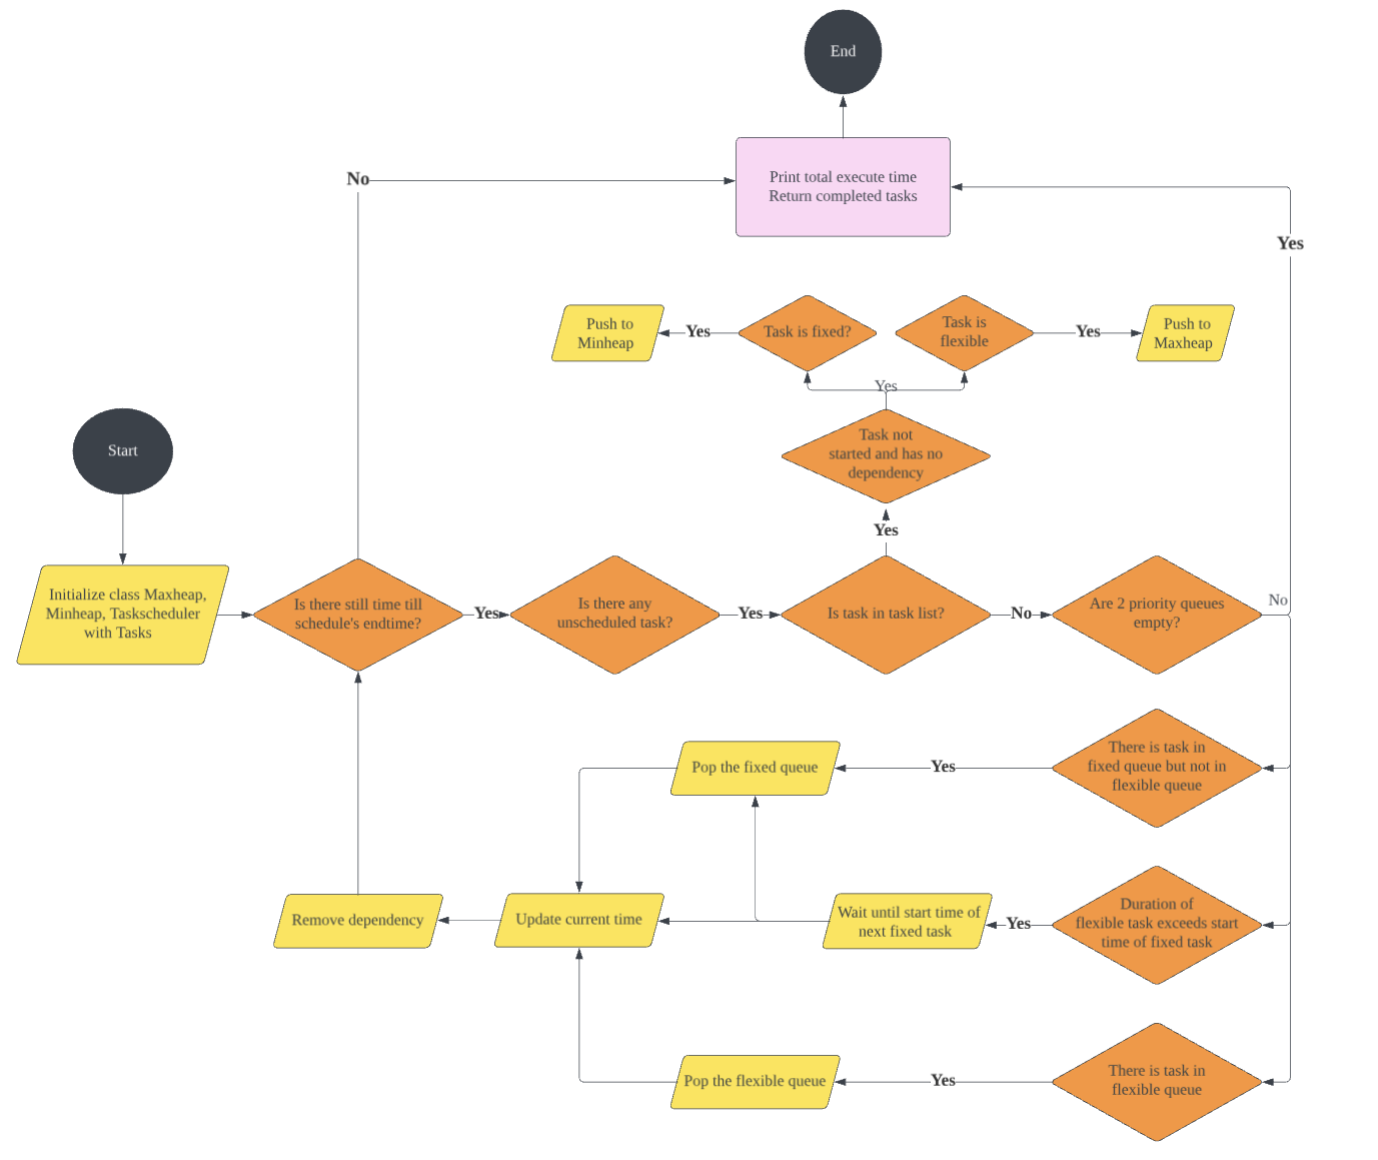

1. **Start**: Begin with a start node.

2. **Load Tasks**: loading tasks into the task scheduler.

3. **Check for the condition to continue running the task scheduler:** check if there are any tasks left to schedule or if there is still time in the day to execute the task. If not, end the process.

4. **Check for the condition to push tasks into queues:** If task status is not started and all of its dependencies have been executed

5. **Update task priority:** Calculate the priority of tasks in relation to the current time that tasks are pushed into queues \(Ready tasks only\)

6. **Push tasks in queue:** Push the tasks into the appropriate priority queue based on whether it is a fixed task or a flexible task or not. 

7. **Check Current Time Against Fixed Task Queue**: check if the current time is equal to or greater than the start time of the next fixed task \(the min element in the fixed task queue\). If yes, execute the fixed task and remove it from the queue.

8. **Check Current Time \+ Duration of Next Flexible Task Against Next Fixed Task**: If the current time is less than the start time of the next fixed task, check if the current time plus the duration of the next flexible task \(the max element in the flexible task queue\) is less than the start time of the next fixed task.

9. **Execute Flexible Task**: If the current time plus the duration of the next flexible task is less than the start time of the next fixed task, execute the flexible task and remove it from the queue.

10. **Update current time:** Increment current time by the duration of the task that just got executed

11. **Loop Back**: Create an arrow from the end of the "Execute Fixed Task" and "Execute Flexible Task" processes back to the "Check if Tasks are Empty" decision box to represent the loop of the task scheduling process.

12. **End**: If there are no tasks left to schedule, end the process.



#### Limitation



- In my design, the fixed tasks are ensured to be scheduled on time since their priority is determined by their start time. However, tasks with deadlines and tasks with ideal start times are kept flexible and they will receive a bonus utility score or penalty score when the current time is in favor of/against those task properties. This leads to the fact that a task might still be finished over the deadline, or out of their ideal time \(e.g. having lunch at 3pm\)

- The design to only push tasks without any dependency into queues is a simplified approach. Let's consider cases when a task is without any deadline, ideal start time, or any importance at all but it does not depend on any other task, for example, learning Korean. It is an optional extracurricular activity for me to immerse more in Korean culture, but I can fo it any time in the day. I do not have to pre\-execute anything before I learn Korean. But still, with this algorithm,  a task may be executed first just because it has no dependency. 

- Also, if the task list starts with every task having a dependency \(circular dependency\), the scheduler will be unable to run. 

- Not being able to handle dynamic changes: The algorithm cannot handle dynamically changing schedules or the addition/removal/ delay of tasks during execution. The schedule assumes that tasks will be perfectly executed at the duration. 

- Unable to optimize: Note that the task scheduler has a wait\_until\_fixed\_time\(\) function in which there will be an empty time slot because the highest\-priority flexible task's duration will exceed the start time of the next fixed task. In real life, we could quickly fit a short\-duration task into this empty space. However, as we store flexible tasks in a Max priority queue, the finding of a task with the minimum duration to fit into that empty space will be O\(n\) time, because finding a minimum element in a maxheap will require traversing through the whole heap to find it. 

- Also maintaining 2 heaps might take more space complexity than using just 1 heap.



### **Complexity Analysis**



The main execution of the algorithm is the run() function.

    def run(self):
        current_time = self.start_time
        print("Running a simple scheduler:\n")

        while self.is_schedule_within_end_time(current_time) and self.are_there_unscheduled_tasks():
            self.get_tasks_ready(current_time)

            if self.should_execute_fixed_task(current_time):
                current_time = self.execute_task_from_queue(self.fixed_tasks_queue, current_time)
            elif self.should_execute_flexible_task():
                current_time = self.execute_task_from_queue(self.flexible_tasks_queue, current_time)

        total_time = current_time - self.start_time
        print(f"\n🕰t={self.format_time(current_time)}")

The run function has a while loop, it iterates through the whole list which takes O(n) times. Each iteration, it calls a function are_there_unscheduled_tasks() to check if there is any task left that is unscheduled by a function check_unscheduled_task()

    def check_unscheduled_tasks(self):
        """
        Evaluates if there are tasks that are still unscheduled
        
        Parameters
        ----------
        None

        Returns
        ----------
        boolean
            True, if there are tasks that are still unscheduled
            False, if there are no tasks that are still unscheduled
        """
        for task in self.tasks:
            if task.status == self.NOT_STARTED:
                return True
        return False   

Note that this function again is a for loop that runs through every task in the task list, which take O(n) time to check its status. Therefore, everytime we push and pop a task, we go through the whole list to check for unscheduled task first. This process takes O(n) time. 

So far, the 2 loops that run through the whole list are nested within each other, so the time complexity so far is O(n^2)



Nested inside the run() function (inside the while loop) is other functions, however, most notable one is another function with a for loop.

In [3]:
    def get_tasks_ready(self, current_time):
        """
        Pushes tasks into the appropriate priority queue
        
        Parameters
        ----------
        None

        Returns
        ----------
        None
        """

        for task in self.tasks:
            if (task.status == self.NOT_STARTED) and not task.dependencies:
                task.priority = self.utility_score (task, current_time)
                task.status = self.IN_PRIORITY_QUEUE
                if task.start_time is not None:
                    self.fixed_tasks_queue.heappush(task)
                else:
                    self.flexible_tasks_queue.heappush(task)

This get_tasks_ready() function contains one for loop which also goes through each task in the task list to check its status and dependency, which takes O(n) time. So overall for each iteration, we go though the whole list to decide which tasks should be pushed into the heap. 

So takes into account the while loop and 2 major functions nested within it (check_unscheduled_task() and get_tasks_ready()), the scaling for the algorithm now is:
O(n) * (O(n) + O(n)) = O(n) * O(n) = O(n^2)

Note that one major confusion here is, one might question, as we push tasks in and pop tasks out of the priority queues gradually in time, shouldn't the size of the task list that we iterate through every time in these 3 functions should decrease? I would say no, as the task list and the priority queues are 2 different data structures to store our tasks. As we push and pop tasks in the priority queue, we make in\-place changes in the self.heap list of the priority queue, not the task list itself \(we just make changes in the task status and dependency of the tasks in task list, not actually remove tasks from the task list\). Therefore, the operation "for task in self.tasks" traverses through exactly n times \(n \- input size\) for each operation.



###### Other operations of the algorithms:



**Operation of the 2 heaps:**

- Find max/ min: Min heap can find the minimum element by simply returning the root which takes O\(1\)

- Heappop: First, heappop exchanges the root with the last element \(this takes O\(1\)\), and decreases the heap size by 1 so that the last element, previously the root, is effectively eliminated from the heap. This takes O\(1\), and then heapify to maintain the heap property that takes O\(log n\). So the total scaling of heappop is O\(log n\).

- Heappush: Similarly for heappop, the heappush algorithm inserts a new key into the heap and performs swapping with the parents if necessary to maintain the heap property. The farthest it can go is to the root, which goes over the height of the heap which is log n. Therefore, the total scaling of heappop is O\(log n\).

- We also call mink\(\) and max\(k\) function to retrieve the root of the queue without removing it. Since we already know the index of the root, this process's runtime is consistently O\(1\) and does not depend on the input size.



However, noted here that n represents the number of objects in the heap at the current time that tasks are pushed into and popped out of. The process happens as below:

- Every task with no dependency will be pushed into the heap \-&gt; The heapify procedure can traverse the key maximumly log m where m represents the number of tasks with no dependency at the current time. 
- Before we push another batch of tasks in, we pop tasks out of the heap \-&gt; The heapify procedure also takes O\(log m\) where m represents the number of tasks with no dependency at the current time. 
- As we remove dependency, there will be new tasks with no dependency pushed into the queue \-&gt; This number makes up for the tasks got popped out, so relatively the time complexity of the priority queue operation is O\(log m\) as explained above



=&gt; Noted that while the heappop function is nested within the while loop, the heappush function is nested within the get\_tasks\_ready\(\) function which we know that take O\(n\) time complexity before. Combining all the major operations, the Scheduler scales with O\(n^2 \* log m\) where m depends on how task dependency is distributed through the task list.


**Other operations:**

- The initialization cost for attributes of different classes is also O(1) because we only initialize them once. As a result, their runtime does not scale with time.

- The "print_self" method has a time complexity of O(N) because it iterates over each task to print their details. However, it is not nested within a loop and is only executed once. Therefore, it does not significantly contribute to the scaling (lower power) of the algorithm.

- The "remove_dependency" method operates with a time complexity of O(N) as it iterates over each task to remove dependencies.

- The "count_dependents" method has a time complexity of O(N) because it iterates over each task to count dependents.

- The "priority_value" method has a time complexity of O(N), where 'N' represents the number of tasks. This is because it invokes the "count_dependents" method, which itself has a time complexity of O(N).

- The "format_time" method boasts a time complexity of O(1) since it solely performs time formatting and does not vary with changes in input size.



##### **Experimental complexity analysis**



I use a random library to generate random attribute for the algorithm.

    tasks = []
    task_ids = list(range(0, n+1))
    activities = ['Cooking Lunch', 'Napping', 'CS110 Pre-Work', 'CS110 Class',
                  'Walking', 'Hiking', 'Internship Applications', 'Civic Project']
    start_time = 0
    current_time = start_time

    for task_id in task_ids:
        activity_ = random.choice(activities)
        duration_ = random.randint(1, 60)
        dependencies_ = random.sample(task_ids[:task_id-1], k=random.randint(0, task_id-1)) if task_id > 1 else []
        random_time = random.randint(1, 23*60)
        start_time_ = random.choice ([None, random_time])
        deadline_ = random.choice ([None, random_time])
        min_ideal_start_ = random.choice ([None, random_time])
        max_ideal_start_ = random.choice ([None, random_time])
        current_time += duration_
        """if current_time > 24 * 60: #This was breaking the loop so I eleminated this
            break"""
        task = Task(id=task_id, description=activity_, duration=duration_, dependencies=dependencies_,
        start_time=start_time_, deadline = deadline_, min_ideal_start = min_ideal_start_, max_ideal_start = max_ideal_start_ )
        tasks.append(task)

    return tasks

Then, I run the runtime plot with input size ranging from 0 to 500 and take the average over 10 experiments \(see the appendix\) to create a runtime plot. The plot shows that the algorithm scales with O\(n^2\), even though the theoretical analysis returns O\(n^2\*log m\). This is due to several reasons, as explaining that m depends on how task dependency is distributed through the task list.

- Since I divided tasks into 2 heaps, the size of each heap reduced significantly. This leads to several outcomes:
  - Balanced Workload: When both heaps have a similar number of tasks, the work performed on each heap is balanced. In each step of the scheduling process, I am either considering the most urgent task from the flexible tasks heap or the next fixed task from the fixed tasks heap. This balance helps maintain a more predictable and consistent time complexity.
  - Parallel Processing: As I process tasks from one heap, I can simultaneously prepare tasks from the other heap. This parallelism can help distribute the work more evenly, potentially reducing the overall runtime.
  - Dependency Handling: If the tasks have dependencies that are evenly distributed across both heaps, the dependency resolution work is also distributed. This can lead to a more consistent time complexity.

- Noting that m is the total number of tasks without dependency, while tasks without dependency are even further distributed into one of the 2 heaps \-&gt; log m will converge to a very small number and got dominated by the n^2 in O\(n^2 log m\)

- The theoretical time complexity accounts for the worst\-case input, while in real life it mostly falls into the best/ average case: If my tasks have limited or shallow dependency structures, where most tasks are independent or have very few dependencies, the time complexity will not significantly increase as I process tasks. In such cases, tasks can be executed with minimal dependencies, reducing the overhead of managing dependencies within the heaps. On another hand, in the worst case, where you have complex dependencies or a dense network of task relationships, the algorithm's performance might degrade significantly. 

- However, I acknowledge the limitation that my input size is too small to reach the asymptotic area which reflects how the algorithm scales as the size of the input increases really large.

Therefore, we can infer that the theoretical analysis was rather far upper bound, the average runtime of the algorithm scales with O\(n^2\). The real runtime of the algorithm might depend on more factors such as the running coding environment, memory management, etc. 



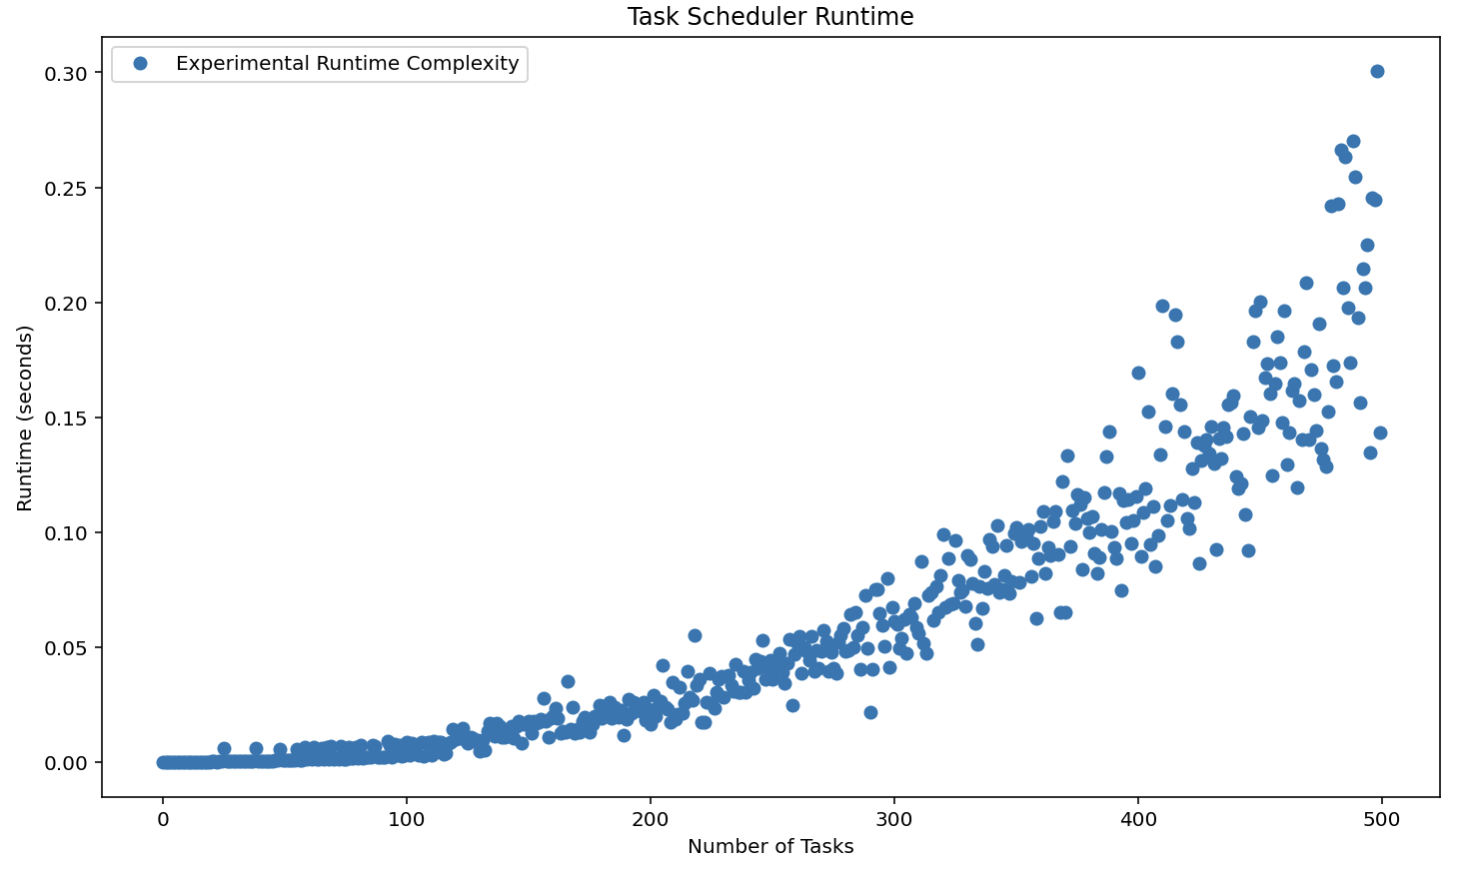

Video Loom walkthrough: https://www.loom.com/share/447eafcd08664c32a85e78157e18cedc?sid=37869341-bb7e-4d29-b38a-6792e7e86221



## Appendix



AI statement: I use ChatGPT to analyze the code that we do in class. I ask chat GPT an opening question in order to get inspiration: How can I adapt this algorithm to a task scheduler. I also use Chat GPT for debugging
Reference: I use the code from the Heapsort session and the TaskScheduler breakout room session


HCs:
#Code Readability: I pay special attention to Code readaibility by organizing the run() function by smaller function with meaningful and intuitive name. We can see that the code for run() is short and understandable from a non-technical standpoint. I paid meticulous attention to code readability by employing clear and purposeful function and class names, along with concise yet informative docstrings and relevant comments. I maintained consistent code formatting and structure, ensuring that distinct classes were organized into separate code cells.

#cs110-AlgoStratDataStruct: In this section, I elucidated the functioning of two distinct algorithmic structures for creating a scheduler. I detailed the setup and operation of these algorithms, highlighted the areas where they fell short of expectations, and proposed methods to enhance them in the upcoming assignment. I bolstered my explanations with the aid of a flowchart. Additionally, I provided an in-depth understanding of the algorithm in a video presentation.

#cs110\-ComplexityAnalysis: I harnessed time complexity to compare various functions and operations in both lists and heaps, ultimately selecting the most suitable option. I conducted an analysis of how these strategies scaled in the context of solving this problem. Finally, I concluded with a comprehensive theoretical assessment, incorporating code snippets and an empirical analysis that involved the use of a random library and the execution of numerous test cases with varying input sizes, complete with the generation of informative graphs. Especially, I pointed out the difference in theoretical and experimental time complexity analysis and explained that difference by analyzing how employing the 2 heap structure will converge O\(n^2 log m\) to O\(n^2\) because of how dependency handling in 2 heaps affects the number of objects usually exist in a heap.

#cs110\-ComputationalCritique: This section commenced with an explanation of the rationale behind choosing the heap data structure over conventional lists. I delved into the benefits of using 2 heaps by outlining these concepts: quickly finding the root of 2 heaps to retrieve the next fixed and flexible task, using 2 different priority values for each type of task, reducing the size of objects in each heap to converge O\(n^2 log m\) to O\(n^2\), etc

#professionalism: I adhered to established coding standards, ensuring the production of efficient code. My report underwent a meticulous grammar review through Grammarly to eliminate any linguistic errors. In addition, I provided an account of the various ways I leveraged AI tools and techniques throughout the assignment.

#cs110-PythonProgramming: Python served as the cornerstone of my implementation strategy. I employed multiple classes, taking advantage of inheritance to leverage attributes and methods across different class instances. Python was also utilized to create code for test cases. Notably, I crafted a function capable of generating randomized input sets and used it to generate graphs that aided in my complexity analysis.



**Max and Min heap**

In [4]:
class MaxHeapq:
    """ 
    A class that implements properties and methods
    that support a max priority queue data structure

    Attributes
    ----------
    heap : arr
        A Python list where key values in the max heap are stored

    heap_size: int
        An integer counter of the number of keys present in the max heap
    """

    def __init__(self):
        """
        Parameters
        ----------
        None
        """
        self.heap = []
        self.heap_size = 0

    def left(self, i):
        """
        Takes the index of the parent node and returns the index of the left child node

        Parameters
        ----------
        i: int
          Index of parent node

        Returns
        ----------
        int
          Index of the left child node
        """
        return 2 * i + 1

    def right(self, i):
        """
        Takes the index of the parent node
        and returns the index of the right child node

        Parameters
        ----------
        i: int
            Index of parent node

        Returns
        ----------
        int
            Index of the right child node
        """
        return 2 * i + 2

    def parent(self, i):
        """
        Takes the index of the child node
        and returns the index of the parent node

        Parameters
        ----------
        i: int
            Index of child node

        Returns
        ----------
        int
            Index of the parent node
        """

        return (i - 1)//2

    def maxk(self):
        """
        Returns the highest key in the priority queue.

        Parameters
        ----------
        None

        Returns
        ----------
        int
            the highest key in the priority queue
        """
        return self.heap[0]

    def heappush(self, key):
        """
        Insert a key into a priority queue

        Parameters
        ----------
        key: int
            The key value to be inserted

        Returns
        ----------
        None
        """
        self.heap.append(float("-inf"))
        self.increase_key(self.heap_size, key)
        self.heap_size += 1

    def increase_key(self, i, key):
        """
        Modifies the value of a key in a max priority queue
        with a higher value

        Parameters
        ----------
        i: int
            The index of the key to be modified
        key: int
            The new key value

        Returns
        ----------
        None
        """

        if key < self.heap[i]:
            raise ValueError('new key is smaller than the current key')
        self.heap[i] = key
        while i > 0 and self.heap[self.parent(i)] < self.heap[i]:
            j = self.parent(i)
            holder = self.heap[j]
            self.heap[j] = self.heap[i]
            self.heap[i] = holder
            i = j

    def heapify(self, i):
        """
        Creates a max heap from the index given

        Parameters
        ----------
        i: int
            The index of of the root node of the subtree to be heapify

        Returns
        ----------
        None
        """
        l = self.left(i)
        r = self.right(i)
        heap = self.heap
        if l <= (self.heap_size-1) and heap[l] > heap[i]:
            largest = l
        else:
            largest = i
        if r <= (self.heap_size-1) and heap[r] > heap[largest]:
            largest = r
        if largest != i:
            heap[i], heap[largest] = heap[largest], heap[i]
            self.heapify(largest)

    def heappop(self):
        """
        Returns the largest key in the max priority queue
        and remove it from the max priority queue

        Parameters
        ----------
        None

        Returns
        ----------
        maxk
            the max value in the heap that is extracted
        """
        if self.heap_size < 1:
            raise ValueError('Heap underflow: There are no keys in the priority queue ')
        maxk = self.heap[0]
        self.heap[0] = self.heap[-1]
        self.heap.pop()
        self.heap_size-=1
        self.heapify(0)
        return maxk

    def __len__(self):
        """
        Get the size of the heap.


        Parameters
        ----------
        None

        Returns
        ----------
        int
            The size of the heap
        """
        return self.heap_size

class MinHeapq:
    def __init__(self):
        self.heap = []
        self.heap_size = 0

    def left(self, i):
        return 2 * i + 1

    def right(self, i):
        return 2 * i + 2

    def parent(self, i):
        return (i-1)//2

    def mink(self):
        return self.heap[0]

    def heappush(self, key):
        self.heap.append(-float("inf"))
        self.decrease_key(self.heap_size,key)
        self.heap_size+=1

    def decrease_key(self, i, key):
        if key < self.heap[i]:
            raise ValueError('new key is larger than the current key')
        self.heap[i] = key
        while i > 0 and self.heap[self.parent(i)] > self.heap[i]:
            j = self.parent(i)
            holder = self.heap[j]
            self.heap[j] = self.heap[i]
            self.heap[i] = holder
            i = j

    def heapify(self, i):
        l = self.left(i)
        r = self.right(i)
        heap = self.heap
        if l <= (self.heap_size-1) and heap[l]<heap[i]:
            smallest = l
        else:
            smallest = i
        if r <= (self.heap_size-1) and heap[r] < heap[smallest]:
            smallest = r
        if smallest != i:
            heap[i], heap[smallest] = heap[smallest], heap[i]
            self.heapify(smallest)

    def heappop(self):
        mink = self.heap[0]
        self.heap[0] = self.heap[-1]
        self.heap.pop()
        self.heap_size-=1
        self.heapify(0)
        return mink
    def __len__(self):
        return self.heap_size

**Class Task**

In [5]:
class Task:
    """A class that represents a task object.

    Attributes:
    - id (int): Unique identifier of the task.
    - description (str): A description of the task.
    - duration (int): The duration of the task.
    - dependencies (list): The list of task IDs that this task depends on.
    - dependents_count (int): The number of tasks that depend on this task.
    - status (str): The status of the task. ('N' for not yet started, 'I' for in priority queue, 'C' for completed).
    - start_time (int, None): The starting time of the task. Set to an integer if it has a fixed starting time, otherwise None.
    - deadline (int, None): The deadline for completing the task. Set to an integer if there's a deadline, otherwise None.
    - min_ideal_start (int, None): The earliest ideal start time for the task.
      Set to an integer if specified, otherwise None.
    - max_ideal_start (int, None): The latest ideal starting time for the task. Set to an integer if specified, otherwise None.
    - end_time (int, None): The completion time of the task. Set to an integer if the task is completed, otherwise None.
    - utility (int): The utility score of the task.
    - priority (int): The priority value of the task.

    Methods:
    - __str__(): Returns a string representation of the task.
    - __lt__(self, other): Compares two tasks based on their priority values.

    """

    def __init__(self, id, description, duration, dependencies, status='N',
                 start_time=None, deadline=None, min_ideal_start=None,
                 max_ideal_start=None):
        self.id = id
        self.description = description
        self.duration = duration
        self.dependencies = dependencies
        self.dependents_count = None
        self.deadline = deadline
        self.min_ideal_start = min_ideal_start
        self.max_ideal_start = max_ideal_start
        self.status = status
        self.start_time = start_time
        self.end_time = None
        self.utility = 10
        self.priority = 0



    def __lt__(self, other):
        """
        Compares two tasks based on their priority values.

        Args:
        - other (Task): Another task to compare to.

        Returns:
        - bool: True if this task's priority is less than the other task's priority.
        """
        if isinstance(other, Task):
            return self.priority < other.priority
        else:
            return False


**Class TaskScheduler**

In [12]:
class TaskScheduler:
    """
    A class that implements properties and methods to support a task scheduler
    using priority queues for flexible and fixed-time tasks.

    Attributes:
    - tasks (list): A list to store task objects.
    - flexible_tasks_queue (MaxHeap): A priority queue for flexible tasks.
    - fixed_tasks_queue (MinHeap): A priority queue for fixed-time tasks.
    - start_time (int): The start time of the scheduler.
    - end_time (int): The end time of the scheduler.
    - completed_tasks (list): A list to store completed tasks.

    Constants:
    - NOT_STARTED (str): Task status for not yet started.
    - IN_PRIORITY_QUEUE (str): Task status for in the priority queue.
    - COMPLETED (str): Task status for completed.

    Methods:
    - task_dependents_count(task): Updates the number of task dependents.
    - utility_score(task, current_time): Calculates the utility score for a task.
    - print_self(): Prints a list of tasks with their properties.
    - format_time(time): Formats time into hours and minutes.
    - get_task_by_id(id): Returns a task object by ID.
    - is_schedule_within_end_time(current_time): Checks if the schedule exceeds the end time.
    - are_there_unscheduled_tasks(): Checks if there are unscheduled tasks.
    - should_execute_fixed_task(current_time): Checks if a fixed-time task should be executed.
    - should_execute_flexible_task(): Checks if a flexible task should be executed.
    - remove_dependency(id): Removes a task ID from dependency lists of other tasks.
    - get_tasks_ready(current_time): Pushes tasks into appropriate priority queues.
    - wait_next_fixed_tasks(task, current_time): Handles waiting for a fixed-time task.
    - execute_task_from_queue(queue, current_time): Executes a task from a priority queue.
    - task_execution(task, current_time): Executes a task and updates its status.
    - run(): Runs the task scheduler until completion.
    """
    NOT_STARTED = 'N'
    IN_PRIORITY_QUEUE = 'I'
    COMPLETED = 'C'

    def __init__(self, tasks, start_time, end_time):

        self.tasks = tasks
        self.flexible_tasks_queue = MaxHeapq()
        self.fixed_tasks_queue = MinHeapq()
        self.start_time = start_time
        self.end_time = end_time
        self.completed_tasks = []

    def task_dependents_count(self, task):
        """
        Updates the number of dependents for a task.

        Parameters:
        - task (Task): The task to update dependents for.

        Returns:
        - int: The number of dependents for the task.
        """
        task.dependents_count = len([t for t in self.tasks if task.id in t.dependencies]) / len(self.tasks)
        return task.dependents_count

    def utility_score(self, task, current_time):
        """
        Calculates the utility score for a task.

        Parameters:
        - task (Task): The task to calculate the utility score for.
        - current_time (int): The current time when calculating the score.

        Returns:
        - int: The utility score for the task.
        """
        task.utility = 10
        if task.start_time is not None:
            task.priority = task.start_time
            return task.priority


        else:
            # Calculate urgency score based on how close the deadline is to current time
            if task.deadline is not None:
                if current_time < task.deadline:
                    urgency_score = 1 - ((task.deadline - current_time - task.duration) / (5*60))
                    task.utility += urgency_score
                else:
                    urgency_score = (task.deadline - current_time - task.duration) / (5*60)
                    task.utility -= urgency_score
            # Calculate score for ideal time range based on how close the current time is to the ideal start time
            ideal_score = 0
            if task.min_ideal_start is not None and task.max_ideal_start is not None:
                if task.min_ideal_start <= current_time <= task.max_ideal_start:
                    score_increment = (task.max_ideal_start - current_time ) / (5*60)
                    ideal_score += score_increment
                elif current_time < task.min_ideal_start:
                    # If the task starts before the ideal start time
                    time_before_start = task.min_ideal_start - current_time
                    score_decrement = time_before_start /(5*60)
                    ideal_score -= score_decrement
                elif current_time > task.max_ideal_start:
                    # If the task starts after the ideal end time
                    time_after_end = current_time - task.max_ideal_start
                    score_decrement = time_after_end / (5*60)
                    ideal_score -= score_decrement
                task.utility += ideal_score

            # Calculate score for dependencies based on how many other tasks are depend on this task
            if self.task_dependents_count(task) > 0:
                dependents_score = self.task_dependents_count(task)
                task.utility += dependents_score

            task.priority = task.utility
            return task.priority

    def print_self(self):
        """
        Prints the full list of tasks, including duration,
        and indicates if a task depends on others

        Parameters
        ----------
        None

        Returns
        ----------
        None
        """
        print("Tasks added to the simple scheduler:")
        print("--------------------------------------")
        for t in self.tasks:
            print(f"➡️'{t.description}', duration = {t.duration} mins.")
            if len(t.dependencies)>0:
                print(f"\t ⚠️ This task depends on others!")
            if t.start_time is not None:
                print(f"\t This task has fixed time!")
            if t.deadline is not None:
                print (f"\t This task has a deadline to finish!")
            if t.min_ideal_start is not None and t.max_ideal_start is not None:
                print(f"\t This task is better done within this time range!")


    def format_time(self, time):
        """
        Formats the time into hours and minutes

        Parameters
        ----------
        time: int
            Time in minutes that is supposed to be formatted

        Returns
        ----------
        str
            Formatted time
        """
        return f"{time//60}h{time%60:02d}"

    def get_task_by_id(self, id):
        """
        Returns the task object with the given id

        Parameters
        ----------
        id: int
             id of the task object to be returned

        Returns
        ----------
        Task
             Task object with the given id
        """
        for task in self.tasks:
             if task.id == id:
                return task
        return None

    
    def is_schedule_within_end_time (self, current_time, show_output = True):
        """
        Checks if the current time exceeds the end time of the schedule.

        Parameters
        ----------
        current_time : int
            The current time in minutes.

        Returns
        ----------
        bool
            True if the current time does not exceed the end time, False otherwise.
        """
        if current_time > self.end_time:
            if show_output: 
                print(f"This task exceeds the end time of your schedule at {self.format_time(self.end_time)}")
                print(f"Did not complete all tasks. Reschedule for tomorrow!")
            return False
        else:
            return True


    def are_there_unscheduled_tasks(self):
        """
        Checks if there are any unscheduled tasks.

        Returns
        ----------
        bool
            True if there are unscheduled tasks, False otherwise.
        """
        return self.check_unscheduled_tasks() or self.flexible_tasks_queue or self.fixed_tasks_queue

    
    
    def check_unscheduled_tasks(self):
        """
        Evaluates if there are tasks that are still unscheduled.

        Returns
        ----------
        bool
            True, if there are tasks that are still unscheduled.
            False, if there are no tasks that are still unscheduled.
        """
        for task in self.tasks:
            if task.status == self.NOT_STARTED:
                return True
        return False

    def should_execute_fixed_task(self, current_time):
        """
        Checks if a fixed task should be executed.

        Parameters
        ----------
        current_time : int
            The current time in minutes.

        Returns
        ----------
        bool
            True if a fixed task should be executed, False otherwise.
        """
        
        return len(self.fixed_tasks_queue) > 0 and (len(self.flexible_tasks_queue) == 0 or (self.fixed_tasks_queue.mink().start_time - current_time) < self.flexible_tasks_queue.maxk().duration)

    
    
    def should_execute_flexible_task(self):
        """
        Checks if a flexible task should be executed.

        Returns
        ----------
        bool
            True if a flexible task should be executed, False otherwise.
        """
        return len(self.flexible_tasks_queue) > 0


    def remove_dependency(self, id):
        """
        Removes the given task id from the dependency lists of other tasks

        Parameters
        ----------
        id: int
            id to be removed from other dependency lists

        Returns
        ----------
        None
        """
        for t in self.tasks:
            if t.id != id and id in t.dependencies:
                t.dependencies.remove(id)

    def get_tasks_ready(self, current_time):
        """
        Pushes tasks into the appropriate priority queue

        Parameters
        ----------
        None

        Returns
        ----------
        None
        """

        for task in self.tasks:
            
            if (task.status == self.NOT_STARTED) and not task.dependencies:
                task.priority = self.utility_score (task, current_time)
                task.status = self.IN_PRIORITY_QUEUE
                if task.start_time is not None:
                    self.fixed_tasks_queue.heappush(task)
                else:
                    self.flexible_tasks_queue.heappush(task)


    def wait_next_fixed_tasks(self, task, current_time, show_output = True):
        """
        Waits until the start time of the next fixed task.

        Parameters
        ----------
        task : Task
            The next fixed task.
        current_time : int
            The current time in minutes.

        Returns
        ----------
        int
            The updated current time.
        """
        
        if show_output:
            print(f"🕰t={self.format_time(current_time)}")
            print(f"☕️ Taking a break of {task.start_time - current_time} minutes so you can start '{task.description}' at {self.format_time(task.start_time)}.")
        current_time = task.start_time
        #current_time += (task.start_time - current_time)
        return current_time



    def execute_task_from_queue(self, queue, current_time, show_output = True):
        """
        Executes the next task from the given queue.

        Parameters
        ----------
        queue : PriorityQueue
            The queue from which to execute the next task.
        current_time : int
            The current time in minutes.

        Returns
        ----------
        int
            The updated current time.
        """
        task = queue.heappop()
        if queue == self.fixed_tasks_queue and task.start_time is not None:
            current_time = self.wait_next_fixed_tasks(task, current_time, show_output)
        return self.task_execution(task, current_time, show_output)


    def task_execution(self, task, current_time, show_output = True):
        """
        Executes the given task.

        Parameters
        ----------
        task : Task
            The task to execute.
        current_time : int
            The current time in minutes.

        Returns
        ----------
        int
            The updated current time.
        """
        if show_output: 
            print(f"\nNext Task:'{task.description}'")
            print(f"🕰t={self.format_time(current_time)}")
            print(f"\tstarted '{task.description}' for {task.duration} mins...")
            current_time += task.duration
            print(f"\t✅ t={self.format_time(current_time)}, task completed with priority = {task.priority}!")
        else: 
            current_time += task.duration
        # If the task is done, remove it from the dependency lists
        self.remove_dependency(task.id)
        task.status = self.COMPLETED
        self.completed_tasks.append(task)
        return current_time


    def run(self, show_output = True):
        current_time = self.start_time
        if show_output: 
            print("Running a simple scheduler:\n")

        while self.is_schedule_within_end_time(current_time, show_output) and self.are_there_unscheduled_tasks():
            self.get_tasks_ready(current_time)

            if self.should_execute_fixed_task(current_time):
                current_time = self.execute_task_from_queue(self.fixed_tasks_queue, current_time, show_output)
            elif self.should_execute_flexible_task():
                current_time = self.execute_task_from_queue(self.flexible_tasks_queue, current_time, show_output)


        total_time = current_time - self.start_time
        if show_output:
            print(f"\n🕰t={self.format_time(current_time)}")

#### **3 test cases**



##### Test case 1



In [7]:
Task0 = Task(id=0, description='get up at 7:00 AM',duration=10, dependencies=[], start_time = 7*60)
Task1 = Task(id=1, description='eat breakfast', duration=15, dependencies=[0])
Task2 = Task(id=2, description='do PCW CS110', duration= 150, dependencies=[1])
Task3 = Task(id=3, description='join class CS110 at 10:00AM', duration=90, dependencies=[2], start_time = 10*60)
Task4 = Task(id=4, description='walk to Namsan Towel', duration=60, dependencies=[3,9])
Task5 = Task(id=5, description='visit Changgyeonggung palace to do AH111 assignment before closing time', duration=120, dependencies=[3,9],  deadline = 17*60)
Task6 = Task(id=6, description='finish AH111 assignment', duration=180, dependencies=[5,7], deadline = 23*60, min_ideal_start = 13*60, max_ideal_start = 19*60)
Task7 = Task(id=7, description='coffee hopping', duration=120, dependencies=[5], min_ideal_start = 13*60, max_ideal_start = 16*60)
Task8 = Task(id=8, description='go to sleep', duration=5, dependencies=[], start_time = 23*60)
Task9 = Task(id=9, description = "have lunch", duration = 50, dependencies = [3], min_ideal_start = 12*60, max_ideal_start = 13*60)

task_list1 = [Task0, Task1, Task2, Task3, Task4, Task5, Task6, Task7, Task8, Task9]
task_scheduler1 = TaskScheduler(tasks = task_list1, start_time = 7*60, end_time = 24*60)
task_scheduler1.print_self()
task_scheduler1.run(show_output = True)

Tasks added to the simple scheduler:
--------------------------------------
➡️'get up at 7:00 AM', duration = 10 mins.
	 This task has fixed time!
➡️'eat breakfast', duration = 15 mins.
	 ⚠️ This task depends on others!
➡️'do PCW CS110', duration = 150 mins.
	 ⚠️ This task depends on others!
➡️'join class CS110 at 10:00AM', duration = 90 mins.
	 ⚠️ This task depends on others!
	 This task has fixed time!
➡️'walk to Namsan Towel', duration = 60 mins.
	 ⚠️ This task depends on others!
➡️'visit Changgyeonggung palace to do AH111 assignment before closing time', duration = 120 mins.
	 ⚠️ This task depends on others!
	 This task has a deadline to finish!
➡️'finish AH111 assignment', duration = 180 mins.
	 ⚠️ This task depends on others!
	 This task has a deadline to finish!
	 This task is better done within this time range!
➡️'coffee hopping', duration = 120 mins.
	 ⚠️ This task depends on others!
	 This task is better done within this time range!
➡️'go to sleep', duration = 5 mins.
	 This 

##### Shuffle test case 1



In [13]:
Task0 = Task(id=0, description='get up at 7:00 AM',duration=10, dependencies=[], start_time = 7*60)
Task1 = Task(id=1, description='eat breakfast', duration=15, dependencies=[0])
Task2 = Task(id=2, description='do PCW CS110', duration= 150, dependencies=[1])
Task3 = Task(id=3, description='join class CS110 at 10:00AM', duration=90, dependencies=[2], start_time = 10*60 - 10)
Task4 = Task(id=4, description='walk to Namsan Towel', duration=60, dependencies=[3,9])
Task5 = Task(id=5, description='visit Changgyeonggung palace to do AH111 assignment before closing time', duration=120, dependencies=[3,9],  deadline = 17*60)
Task6 = Task(id=6, description='finish AH111 assignment', duration=180, dependencies=[5,7], deadline = 23*60, min_ideal_start = 13*60, max_ideal_start = 19*60)
Task7 = Task(id=7, description='coffee hopping', duration=120, dependencies=[5], min_ideal_start = 13*60, max_ideal_start = 16*60)
Task8 = Task(id=8, description='go to sleep', duration=5, dependencies=[], start_time = 23*60)
Task9 = Task(id=9, description = "have lunch", duration = 50, dependencies = [3], min_ideal_start = 12*60, max_ideal_start = 13*60)

shuffled_task_list1 = [Task4, Task1, Task0, Task2, Task6, Task5, Task3, Task8, Task9, Task7]
shuffled_taskscheduler1 = TaskScheduler(tasks = shuffled_task_list1, start_time = 7*60, end_time = 24*60)
shuffled_taskscheduler1.run()

Running a simple scheduler:

🕰t=7h00
☕️ Taking a break of 0 minutes so you can start 'get up at 7:00 AM' at 7h00.

Next Task:'get up at 7:00 AM'
🕰t=7h00
	started 'get up at 7:00 AM' for 10 mins...
	✅ t=7h10, task completed with priority = 420!

Next Task:'eat breakfast'
🕰t=7h10
	started 'eat breakfast' for 15 mins...
	✅ t=7h25, task completed with priority = 10.1!

Next Task:'do PCW CS110'
🕰t=7h25
	started 'do PCW CS110' for 150 mins...
	✅ t=9h55, task completed with priority = 10.1!
🕰t=9h55
☕️ Taking a break of -5 minutes so you can start 'join class CS110 at 10:00AM' at 9h50.

Next Task:'join class CS110 at 10:00AM'
🕰t=9h50
	started 'join class CS110 at 10:00AM' for 90 mins...
	✅ t=11h20, task completed with priority = 590!

Next Task:'have lunch'
🕰t=11h20
	started 'have lunch' for 50 mins...
	✅ t=12h10, task completed with priority = 10.066666666666666!

Next Task:'visit Changgyeonggung palace to do AH111 assignment before closing time'
🕰t=12h10
	started 'visit Changgyeonggung palac

###### Using assert to showcase that Shuffle test case 1  creates the same output as test case 1. We can conclude that the Taskscheduler is prioritize task based on utility, not IDs.



In [ ]:
output_scheduler1 = list([i.id for i in task_scheduler1.completed_tasks])
output_shuffled_scheduler1 = list([i.id for i in shuffled_taskscheduler1.completed_tasks])
print(output_scheduler1)
print(output_shuffled_scheduler1)
assert output_scheduler1 ==  output_shuffled_scheduler1

[0, 1, 2, 3, 9, 5, 7, 6, 4, 8]
[0, 1, 2, 3, 9, 5, 7, 6, 4, 8]


#### **Other test cases**



##### Test case 2



In [ ]:
Task0 = Task(id=0, description='get up at 7:00 AM',duration=10, dependencies=[], start_time = 7*60)
Task1 = Task(id=1, description='do yoga', duration=15, dependencies=[0])
Task2 = Task(id=2, description='cooking', duration= 150, dependencies=[])
Task3 = Task(id=3, description='picnic at Olympic Park', duration=180, dependencies=[2])
Task4 = Task(id=4, description='do CS110 assignment at Namsanlibrary', duration=120, dependencies=[5], deadline = 23*60)
Task5 = Task(id=5, description='walk to Namsan library', duration=20, dependencies=[])
Task6 = Task(id=6, description='applying for internship', duration=120, dependencies=[4])
Task7 = Task(id=7, description='sleep early today', duration=5, dependencies=[], start_time = 21*60)
Task8 = Task(id=8, description='go thrifting at Dongmyo market', duration=400, dependencies=[4])

task_list2 = [Task0, Task1, Task2, Task3, Task4, Task5, Task6, Task7, Task8]
task_scheduler2 = TaskScheduler(tasks = task_list2, start_time = 7*60, end_time = 22*60)
task_scheduler2.print_self()
task_scheduler2.run()


Tasks added to the simple scheduler:
--------------------------------------
➡️'get up at 7:00 AM', duration = 10 mins.
	 This task has fixed time!
➡️'do yoga', duration = 15 mins.
	 ⚠️ This task depends on others!
➡️'cooking', duration = 150 mins.
➡️'picnic at Olympic Park', duration = 180 mins.
	 ⚠️ This task depends on others!
➡️'do CS110 assignment at Namsanlibrary', duration = 120 mins.
	 ⚠️ This task depends on others!
	 This task has a deadline to finish!
➡️'walk to Namsan library', duration = 20 mins.
➡️'applying for internship', duration = 120 mins.
	 ⚠️ This task depends on others!
➡️'sleep early today', duration = 5 mins.
	 This task has fixed time!
➡️'go thrifting at Dongmyo market', duration = 400 mins.
	 ⚠️ This task depends on others!
Running a simple scheduler:

🕰t=7h00
☕️ Taking a break of 0 minutes so you can start 'get up at 7:00 AM' at 7h00.

Next Task:'get up at 7:00 AM'
🕰t=7h00
	started 'get up at 7:00 AM' for 10 mins...
	✅ t=7h10, task completed with priority = 42

##### Test case 3



In [ ]:
Task0 = Task(id=0, description='get up at 7:00 AM',duration=10, dependencies=[], start_time = 7*60)
Task1 = Task(id=1, description='attend WS meeting', duration=100, dependencies=[0], start_time = 8*60)
Task2 = Task(id=2, description='attend CS111 class', duration= 90, dependencies=[], start_time = 10*60)
Task3 = Task(id=3, description='attend History tour', duration=90, dependencies=[], start_time = 14*60)
Task4 = Task(id=4, description='do grocery shopping', duration=30, dependencies=[], deadline = 17*60)
Task5 = Task(id=5, description='do CS111 assignment', duration=180, dependencies=[], deadline = 23*60)
Task6 = Task(id=6, description='attend Office hour CS111', duration=30, dependencies=[], start_time = 17*60)
Task7 = Task(id=7, description='go to the gym', duration=180, dependencies=[], min_ideal_start = 13*60, max_ideal_start = 17*60)
Task8 = Task(id=9, description = "have lunch", duration = 50, dependencies = [2], min_ideal_start = 12*60, max_ideal_start = 13*60)

task_list3 = [Task0, Task1, Task2, Task3, Task4, Task5, Task6, Task7, Task8]
task_scheduler3 = TaskScheduler(tasks = task_list3, start_time = 7*60, end_time = 24*60)
task_scheduler3.print_self()
task_scheduler3.run()


Tasks added to the simple scheduler:
--------------------------------------
➡️'get up at 7:00 AM', duration = 10 mins.
	 This task has fixed time!
➡️'attend WS meeting', duration = 100 mins.
	 ⚠️ This task depends on others!
	 This task has fixed time!
➡️'attend CS111 class', duration = 90 mins.
	 This task has fixed time!
➡️'attend History tour', duration = 90 mins.
	 This task has fixed time!
➡️'do grocery shopping', duration = 30 mins.
	 This task has a deadline to finish!
➡️'do CS111 assignment', duration = 180 mins.
	 This task has a deadline to finish!
➡️'attend Office hour CS111', duration = 30 mins.
	 This task has fixed time!
➡️'go to the gym', duration = 180 mins.
	 This task is better done within this time range!
➡️'have lunch', duration = 50 mins.
	 ⚠️ This task depends on others!
	 This task is better done within this time range!
Running a simple scheduler:

🕰t=7h00
☕️ Taking a break of 0 minutes so you can start 'get up at 7:00 AM' at 7h00.

Next Task:'get up at 7:00 AM'


### **Experimental time complexity analysis**



##### Generate Test Cases to check Time Complexity



In [ ]:
import random
from datetime import timedelta

def generate_test_cases_random_input(n):
    """
    Generates a list of n test cases for task scheduling.

    Each task is represented as a dictionary with the following keys:
    - 'id': a unique identifier for the task.
    - 'description': a string describing the task.
    - 'duration': the duration of the task in minutes
    - 'dependencies': a list of task ids that this task depends on.
    - 'flexibility': a boolean indicating whether the task is flexible.
    - 'start_time': the start time of the task in minutes past midnight.

    The tasks are generated with random durations up to 60 minutes, random dependencies,
    and random flexibilities. The start times are calculated to ensure that they do not overlap
    and that all tasks can be finished within 24 hours.

    Returns:
        A list of dictionaries representing the tasks.
    """
    tasks = []
    task_ids = list(range(0, n+1))
    activities = ['Cooking Lunch', 'Napping', 'CS110 Pre-Work', 'CS110 Class',
                  'Walking', 'Hiking', 'Internship Applications', 'Civic Project']
    start_time = 0
    current_time = start_time

    for task_id in task_ids:
        activity_ = random.choice(activities)
        duration_ = random.randint(1, 60)
        dependencies_ = random.sample(task_ids[:task_id-1], k=random.randint(0, task_id-1)) if task_id > 1 else []
        random_time = random.randint(1, 23*60)
        start_time_ = random.choice ([None, random_time])
        deadline_ = random.choice ([None, random_time])
        min_ideal_start_ = random.choice ([None, random_time])
        max_ideal_start_ = random.choice ([None, random_time])
        current_time += duration_
        task = Task(id=task_id, description=activity_, duration=duration_, dependencies=dependencies_,
        start_time=start_time_, deadline = deadline_, min_ideal_start = min_ideal_start_, max_ideal_start = max_ideal_start_ )
        tasks.append(task)

    return tasks

##### Run the averaged runtime



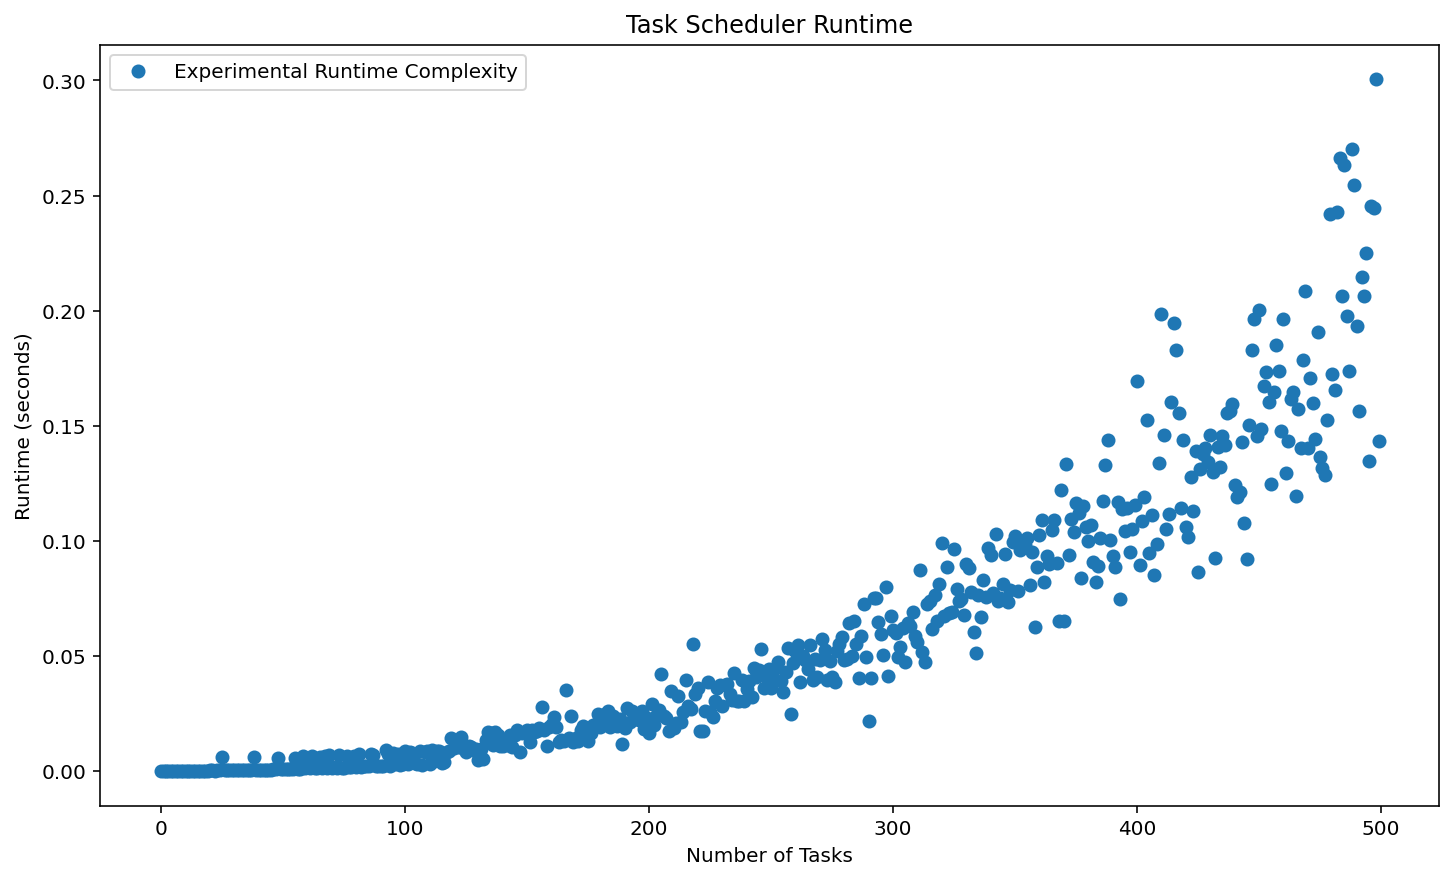

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt


avg_runtime = []
experiments = 10
input_size = list(range(0, 500))
for size in input_size:
    runtime = []
    for i in range(experiments):
        test_cases = generate_test_cases_random_input(size)
        scheduler = TaskScheduler(test_cases, start_time = 0*60, end_time = 24*60)
        start_time = time.time()
        scheduler.run(show_output = False)
        end_time = time.time()
        runtime.append (end_time - start_time)
    avg_runtime.append(sum(runtime)/len(runtime))


plt.plot(input_size, avg_runtime, 'o', label = "Experimental Runtime Complexity")
plt.title("Task Scheduler Runtime")
plt.xlabel("Number of Tasks")
plt.ylabel("Runtime (seconds)")
plt.legend()
plt.show()




In [ ]:
import pandas as pd
import numpy as np
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSLIjzGAej8iHiyPXVGS35d5qf8ZEwfD1fwQkrgcdDue2bMNG_5v0ifrTlK1n9r'
df = pd.read_csv(url, )
df = df.replace(np.nan, None)

HTTPError: HTTP Error 404: Not Found